## Imports/Datasets

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import random
import numpy as np
import math
from scipy.stats import multivariate_normal
import seaborn as sns

seasons_df = pd.read_csv('/Users/josephsun/Desktop/M4R/code/premier-league-matches.csv')
tables_df = pd.read_csv('/Users/josephsun/Desktop/M4R/code/pl-tables-1993-2024.csv')

In [4]:
recent = seasons_df[seasons_df['Season_End_Year'] == 2023] #2023 season
recent_previous = seasons_df[seasons_df['Season_End_Year'] == 2022]
initial_season = seasons_df[seasons_df['Season_End_Year'] == 1993]
"""" 
Schema: 
Season_End_Year
Wk
Date
Home
HomeGoals
AwayGoals
Away
FTR
"""

'" \nSchema: \nSeason_End_Year\nWk\nDate\nHome\nHomeGoals\nAwayGoals\nAway\nFTR\n'

## MCMC functions

In [5]:
def llk(rate, k):
    return - rate + k * np.log(rate) - np.log(math.factorial(k))

def sample_score(home_strength, away_strength, home_advantage, away_advantage):
    """ 
    sample score, calculate likelihood
    """
    exp_diff = np.exp(home_strength - away_strength)

    home_rate = home_advantage * exp_diff
    away_rate = away_advantage / exp_diff

    home_score = np.random.poisson(home_rate)
    away_score = np.random.poisson(away_rate)

    home_llk = llk(home_rate, home_score)
    away_llk = llk(away_rate, away_score)

    return [[home_score, away_score], home_llk + away_llk]

def score_llk(home_score, away_score, home_strength, away_strength, home_advantage, away_advantage):
    """ 
    get likelihood of score
    """
    exp_diff = np.exp(home_strength - away_strength)

    home_rate = home_advantage * exp_diff
    away_rate = away_advantage / exp_diff

    home_llk = llk(home_rate, home_score)
    away_llk = llk(away_rate, away_score)
    return home_llk + away_llk

In [6]:
def get_teams(season_df):
    """ 
    Get the list of teams from a season

    Inputs:
    season_df - dataframe containing season's results

    Outputs:
    teams - list of team names
    """
    teams = sorted(season_df['Home'][:100].unique())
    return teams

def initialise_strengths(teams, mu_p, sigma_p):
    """
    Initialise the strengths for a list of teams

    Inputs:
    teams - list of teams 
    
    Outputs:
    strengths_df - dataframe of teams and strengths
    """
    team_strengths = np.random.normal(loc=mu_p, scale=sigma_p, size=len(teams))

    strengths_df = pd.DataFrame({
    "Team Name": teams,
    "Strength": team_strengths
    })
    
    return strengths_df

def initialise_parameters():
    return {'Home Advantage': [np.random.gamma(1.5, 1)], #mean = shape * scale
            'Away Advantage': [np.random.gamma(2.5, 0.5)],
            'Eta': [np.random.normal(1, 1)],
            'Sigma_S': [np.random.uniform(0, 1)],
            'Mu_P': [np.random.normal(0, 1)],
            'Sigma_P': [np.random.uniform(0, 1)]}


In [7]:
np.random.gamma(2, 1)

1.1280315759291566

In [8]:
get_teams(recent) #team names

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brentford',
 'Brighton',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Leeds United',
 'Leicester City',
 'Liverpool',
 'Manchester City',
 'Manchester Utd',
 'Newcastle Utd',
 "Nott'ham Forest",
 'Southampton',
 'Tottenham',
 'West Ham',
 'Wolves']

In [9]:
def initial_prior_strengths(strengths_df, mu_p, sigma_p):
    """ 
    Prior log likelihood for initial strengths

    Inputs:
    strengths_df - dataframe of team strengths
    mu_p - promoted team mean
    sigma_p - promoted team standard deviation
    
    Outputs:
    llk - log likelihood for initial strengths
    """

    strengths = strengths_df['Strength']

    llk = multivariate_normal.logpdf(
        strengths,
        mean = np.full(len(strengths), mu_p),
        cov=np.eye(len(strengths)) * (sigma_p**2)
    )

    return llk


In [10]:
def strength_llk(strengths, scores, home_advantage, away_advantage):
    #To do: Add parameter sampling
    """ 
    Inputs:
    Strengths - Dataframe containing strengths for each team
    Scores - Dataframe containing scores for season 

    Returns:
    Log likelihood of scores given parameters
    """

    home_join = pd.merge(scores, strengths, left_on = "Home", right_on = "Team Name").rename(columns = {"Strength": "HomeStrength"})
    away_join = pd.merge(home_join, strengths, left_on = "Away", right_on = "Team Name").rename(columns = {"Strength": "AwayStrength"})

    away_join['Llk'] = away_join.apply(
        lambda row: pd.Series(score_llk(row["HomeGoals"], row["AwayGoals"], row["HomeStrength"], row["AwayStrength"],
                                        home_advantage, away_advantage)), axis = 1)

    return away_join["Llk"].sum()



## MCMC(Initial Season)

In [133]:
def mcmc_initial(season_df, burn_in = 1000, iterations = 5000):
    """ 
    Mcmc algorithm

    Inputs:
    season_df - dataframe containing season results
    mu_p - promoted team mean
    sigma_p - promoted team std
    
    Outputs:
    strengths_history - list of strength dataframes
    """
    #initialise parameters
    parameters = initialise_parameters()
    #parameter_names = ['Strength', 'Home Advantage', 'Away Advantage', 'Mu_P', 'Sigma_P']
    lambda_h = parameters['Home Advantage'][0]
    lambda_a = parameters['Away Advantage'][0]
    mu_p = parameters['Mu_P'][0]
    sigma_p = parameters['Sigma_P'][0]

    # Acceptance tracking
    acceptance_counters = {
        'Strength': {'accepted': 0, 'total': 0},
        'Home Advantage': {'accepted': 0, 'total': 0},
        'Away Advantage': {'accepted': 0, 'total': 0},
        'Mu_P': {'accepted': 0, 'total': 0},
        'Sigma_P': {'accepted': 0, 'total': 0},
    }
    
    
    teams = get_teams(season_df) #get team names
    num_teams = len(teams) #get total number of teams
    strength_df = initialise_strengths(teams, mu_p, sigma_p) #initialise team strengths
    parameters['Strength'] = [strength_df] #store initial strengths in parameter dataframe
    cov_matrix = 0.0002 * np.eye(num_teams) #can adjust

    current_log_prob = (
    initial_prior_strengths(strength_df, mu_p, sigma_p)
    + strength_llk(strength_df, season_df, lambda_h, lambda_a))

    current_lambda_h_prob = current_log_prob
    current_lambda_a_prob = current_log_prob
    current_promoted_prob = current_log_prob


    for i in range(burn_in + iterations):
        if np.random.uniform(0, 1) < 0.8: #strength proposal
            if i >= burn_in:
                acceptance_counters['Strength']['total'] += 1 #add to total iterations
            proposed_strength = np.random.multivariate_normal(strength_df['Strength'], cov_matrix)
            proposed_strength_df = strength_df.copy()
            proposed_strength_df['Strength'] = proposed_strength  # Update strength

            proposed_log_prob = (
            initial_prior_strengths(proposed_strength_df, mu_p, sigma_p)
            + strength_llk(proposed_strength_df, season_df, lambda_h, lambda_a)
            )

            prob_acceptance = np.exp(min(0, proposed_log_prob - current_log_prob))
            if np.random.uniform(0, 1) < prob_acceptance:
                strength_df = proposed_strength_df
                current_log_prob = proposed_log_prob
                if i >= burn_in:
                    acceptance_counters['Strength']['accepted'] += 1
            
            parameters['Strength'].append(strength_df)
        else:
            proposed_strength_df = strength_df.copy()
            index = np.random.randint(1, 4)
            if index == 1: #update home advantage
                if i >= burn_in:
                    acceptance_counters['Home Advantage']['total'] += 1
                proposed_lambda_h = np.random.lognormal(np.log(lambda_h), 0.01) #maybe adjust sigma here
                proposed_lambda_h_prob = (
                    initial_prior_strengths(proposed_strength_df, mu_p, sigma_p)
                    + strength_llk(proposed_strength_df, season_df, proposed_lambda_h, lambda_a)
                )
                prob_acceptance = np.exp(min(0, proposed_lambda_h_prob - current_lambda_h_prob))
                if np.random.uniform(0, 1) < prob_acceptance:
                    lambda_h = proposed_lambda_h
                    current_lambda_h_prob = proposed_lambda_h_prob
                    if i >= burn_in:
                        acceptance_counters['Home Advantage']['accepted'] += 1
                parameters['Home Advantage'].append(lambda_h)
            elif index == 2: #update away advantage
                if i >= burn_in:
                    acceptance_counters['Away Advantage']['total'] += 1
                proposed_lambda_a = np.random.lognormal(np.log(lambda_a), 0.01) #maybe adjust sigma here
                proposed_lambda_a_prob = (
                    initial_prior_strengths(proposed_strength_df, mu_p, sigma_p)
                    + strength_llk(proposed_strength_df, season_df, lambda_h, proposed_lambda_a)
                )
                prob_acceptance = np.exp(min(0, proposed_lambda_a_prob - current_lambda_a_prob))
                if np.random.uniform(0, 1) < prob_acceptance:
                    lambda_a = proposed_lambda_a
                    current_lambda_a_prob = proposed_lambda_a_prob
                    if i >= burn_in:
                        acceptance_counters['Away Advantage']['accepted'] += 1
                parameters['Away Advantage'].append(lambda_a)
            elif index == 3: #update promoting parameters
                if i >= burn_in:
                    acceptance_counters['Mu_P']['total'] += 1
                    acceptance_counters['Sigma_P']['total'] += 1
                proposed_mu_p = np.random.normal(mu_p, np.sqrt(0.0002))
                proposed_sigma_p = np.random.lognormal(np.log(sigma_p), np.sqrt(0.002))
                proposed_promoted_prob = (
                    initial_prior_strengths(proposed_strength_df, proposed_mu_p, proposed_sigma_p)
                    + strength_llk(proposed_strength_df, season_df, lambda_h, lambda_a)
                )
                prob_acceptance = np.exp(min(0, proposed_promoted_prob - current_promoted_prob))
                if np.random.uniform(0, 1) < prob_acceptance:
                    mu_p = proposed_mu_p
                    sigma_p = proposed_sigma_p
                    current_promoted_prob = proposed_promoted_prob
                    if i >= burn_in:
                        acceptance_counters['Mu_P']['accepted'] += 1
                        acceptance_counters['Sigma_P']['accepted'] += 1
                parameters['Mu_P'].append(mu_p)
                parameters['Sigma_P'].append(sigma_p)
                
    for parameter in acceptance_counters:
        accepted = acceptance_counters[parameter]['accepted']
        total = acceptance_counters[parameter]['total']
        acceptance_counters[parameter]['percentage'] = (accepted / total * 100) #calculate acceptance percentage

        parameters[parameter] = parameters[parameter][-total:] #take off burn in

    return [parameters, acceptance_counters]

In [134]:
mcmc_recent, acceptance_counters = mcmc_initial(recent, burn_in = 3000, iterations = 15000)

In [135]:
mcmc_recent

{'Home Advantage': [2.0622753249398467,
  2.065210407145428,
  2.065210407145428,
  2.065210407145428,
  2.065210407145428,
  2.065210407145428,
  2.065210407145428,
  2.065210407145428,
  2.0632543571443502,
  2.0636775427246143,
  2.0407186830095307,
  2.053170400712199,
  2.053170400712199,
  2.0560129119071324,
  2.0560129119071324,
  2.058640026985625,
  2.0504734902393875,
  2.0626999182742316,
  2.0626999182742316,
  2.0628044251102495,
  2.0628044251102495,
  2.0628044251102495,
  2.0628044251102495,
  2.0518510535640897,
  2.0518510535640897,
  2.0518510535640897,
  2.0518510535640897,
  2.0407046596323903,
  2.0333450093131415,
  2.0333450093131415,
  2.0333450093131415,
  2.005526282001165,
  1.9925267061400174,
  1.956976496665636,
  1.9410110171833825,
  1.9317408225489627,
  1.9169222049846,
  1.885941269156114,
  1.9109990274816724,
  1.9109990274816724,
  1.9109990274816724,
  1.9109990274816724,
  1.9109990274816724,
  1.9109990274816724,
  1.9109990274816724,
  1.9109

In [136]:
acceptance_counters

{'Strength': {'accepted': 8791,
  'total': 12074,
  'percentage': 72.80934238860361},
 'Home Advantage': {'accepted': 179,
  'total': 967,
  'percentage': 18.510858324715613},
 'Away Advantage': {'accepted': 212,
  'total': 958,
  'percentage': 22.129436325678498},
 'Mu_P': {'accepted': 256, 'total': 1001, 'percentage': 25.574425574425575},
 'Sigma_P': {'accepted': 256, 'total': 1001, 'percentage': 25.574425574425575}}

In [137]:
def strengths_by_team(mcmc_results):
    mcmc_results = [df.set_index('Team Name') for df in mcmc_results]
    joined_df = pd.concat(mcmc_results, axis = 1)
    joined_df['Strength History'] = joined_df.values.tolist()
    return joined_df[['Strength History']].reset_index()

In [138]:
strength_histories = strengths_by_team(mcmc_recent['Strength'])

/var/folders/k6/9xc0dh5s7dv0mk7cjplncm6w0000gn/T/ipykernel_20265/3435341792.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined_df['Strength History'] = joined_df.values.tolist()


## Diagnostic Plots

In [139]:
def trace_plot_strength(strength_histories, teams):
    strength_dict = {team: strength_histories.loc[strength_histories['Team Name'] == team, 'Strength History'].values[0] for team in teams}
    plt.figure(figsize=(10, 5))

    for team, strengths in strength_dict.items():
        plt.plot(strengths, label=team)

    plt.xlabel("Iteration")
    plt.ylabel("Strength")

    plt.title("Trace Plot of Team Strengths Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()


In [140]:
def trace_plot_parameter(parameter, parameter_dict):
    parameter_vals = parameter_dict[parameter]
    plt.plot(parameter_vals)
    plt.xlabel("Iteration")
    plt.ylabel(parameter)

    plt.title(f"Trace Plot of {parameter} Over Iterations")
    plt.grid(True)
    plt.show()

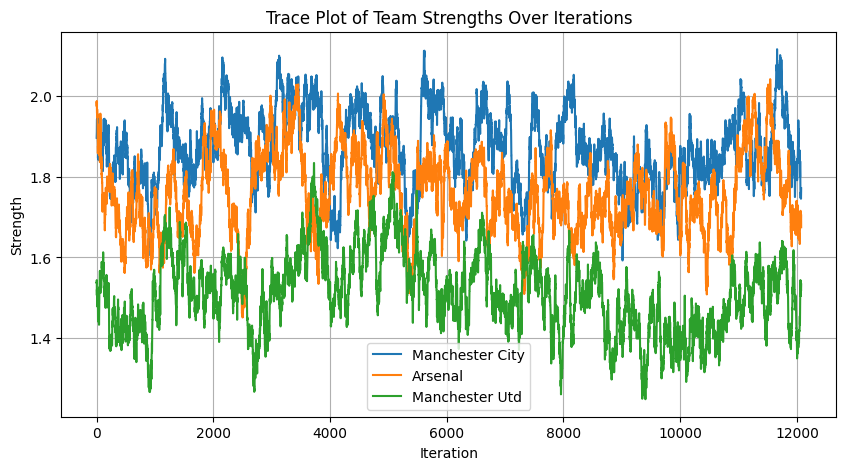

In [141]:
trace_plot_strength(strength_histories, ['Manchester City', 'Arsenal', 'Manchester Utd'])

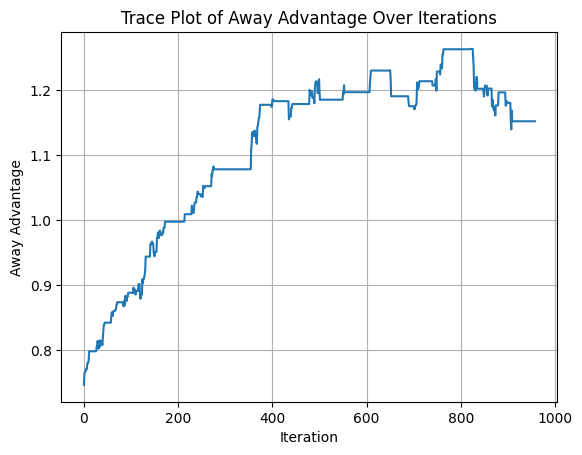

In [142]:
trace_plot_parameter("Away Advantage", mcmc_recent)

In [143]:
#plot of likelihood against iteration

In [144]:
#diagnostic plots to do
#distribution plot
#head to head plot
#auto correlation plot

In [145]:
def comparison_plot(strength_histories, team1, team2):
    team1_strengths = strength_histories.loc[strength_histories['Team Name'] == team1, 'Strength History'].values[0]
    team2_strengths = strength_histories.loc[strength_histories['Team Name'] == team2, 'Strength History'].values[0]

    team1_wins = sum(t1 > t2 for t1, t2 in zip(team1_strengths, team2_strengths))
    total_iterations = len(team1_strengths)
    percentage_team1_stronger = (team1_wins / total_iterations) * 100

    print(f"{team1}'s strength was greater than {team2}'s strength in {percentage_team1_stronger}% of the iterations")

    colors = ['blue' if t1 > t2 else 'red' for t1, t2 in zip(team1_strengths, team2_strengths)]

    # Create scatter plot
    plt.figure(figsize=(6, 6))
    sns.kdeplot(x = team1_strengths, y = team2_strengths, fill=True, cmap="Blues", levels=20, alpha=1)

    # Plot the diagonal line (y = x) for reference
    min_val = min(min(team1_strengths), min(team2_strengths))
    max_val = max(max(team1_strengths), max(team2_strengths))
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', linewidth=1)

    # Labels and title
    plt.xlabel(f"{team1} Strength")
    plt.ylabel(f"{team2} Strength")
    plt.title(f"Strength Comparison: {team1} vs {team2}")

    # Legend
    plt.scatter([], [], color='blue', label=f"{team1} stronger")
    plt.scatter([], [], color='red', label=f"{team2} stronger")
    #plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()


#https://en.wikipedia.org/wiki/Credible_interval#/media/File:Highest_posterior_density_interval.svg


Manchester City's strength was greater than Arsenal's strength in 82.72320689083982% of the iterations


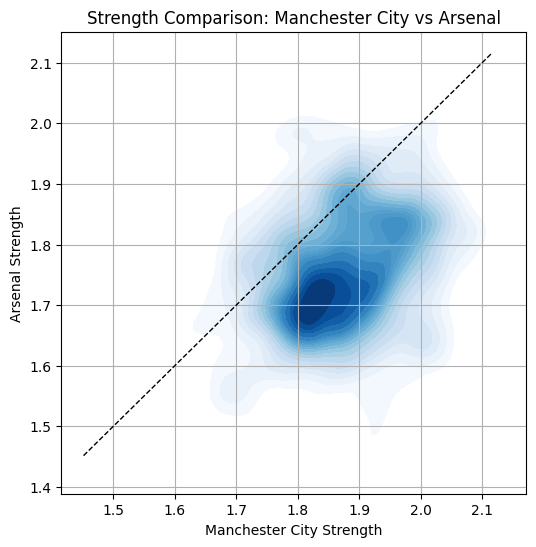

In [146]:
comparison_plot(strength_histories, 'Manchester City', 'Arsenal')

In [196]:
def strength_histogram(strength_histories, team1, team2, bins=30):

    team1_strengths = strength_histories.loc[strength_histories['Team Name'] == team1, 'Strength History'].values[0]
    team2_strengths = strength_histories.loc[strength_histories['Team Name'] == team2, 'Strength History'].values[0]

    print(len(team1_strengths))
    print(len(team2_strengths))

    plt.figure(figsize=(8, 5))
    plt.hist(team1_strengths, bins=bins, alpha=0.5, color='blue', label=team1, edgecolor='black')
    plt.hist(team2_strengths, bins=bins, alpha=0.5, color='red', label=team2, edgecolor='black')

    plt.xlabel("Strength")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Strengths: {team1} vs {team2}")
    plt.legend()

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


8615
8615


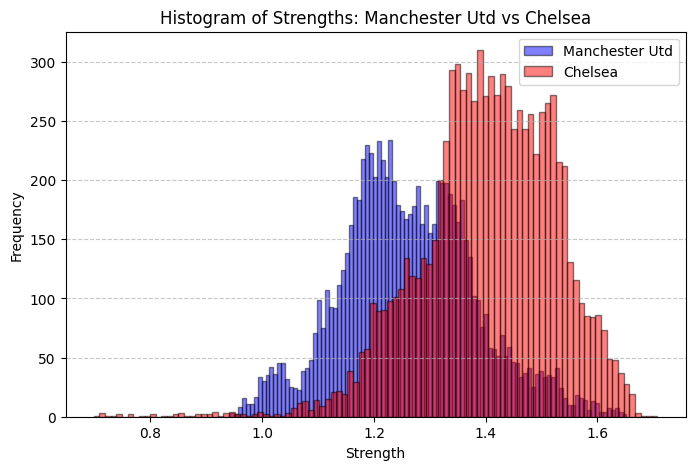

In [204]:
strength_histogram(strength_histories_one, 'Manchester Utd', 'Chelsea', bins = 100)

12074
12074


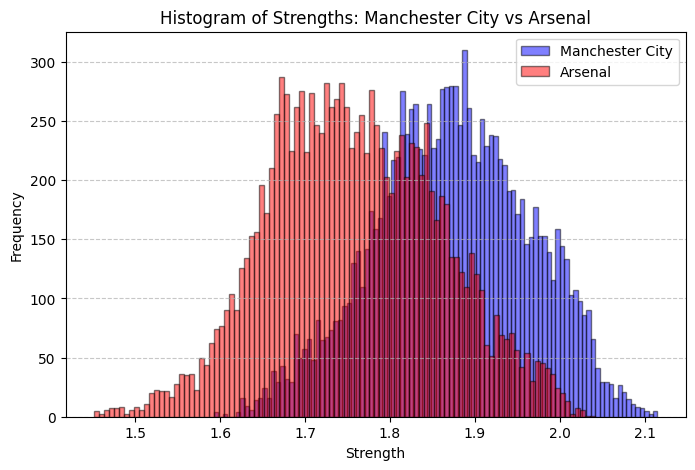

In [203]:
strength_histogram(strength_histories, 'Manchester City', 'Arsenal', bins = 100)


In [149]:
def autocorrelation(samples, lag):
    n = len(samples)
    mean = np.mean(samples)
    var = np.var(samples)
    cov = np.sum((samples[:n-lag] - mean) * (samples[lag:] - mean)) / n #covariance calculation
    return cov / var    #autocorrelation = covariance/variance

In [150]:
def find_neg_index(arr):
    for i, num in enumerate(arr):
        if num < 0:
            return i
    return -1  # Return last index if no negative

def autocorrelation_plot(strength_histories, team, max_lag=False):
    team_strengths = strength_histories.loc[strength_histories['Team Name'] == team, 'Strength History'].values[0]


    acf_values_all = [autocorrelation(team_strengths, lag) for lag in range(len(team_strengths))]
    index = find_neg_index(acf_values_all)

    acf_values = acf_values_all[:index]
    N = len(team_strengths)
    sum_acf = np.sum(acf_values)
    ess = N / (1 + 2 * sum_acf)
    
    print(f"Effective Sample Size for {team}: {ess} out of {N}")

    plt.figure(figsize=(8, 5))
    plt.bar(range(index), acf_values, color='blue', alpha=0.6)
    
    plt.axhline(0, color='black', linewidth=1)
    
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title(f"Autocorrelation Diagnostic Plot for {team}")
    plt.legend()

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return acf_values_all


Effective Sample Size for Arsenal: 52.14213540920637 out of 12074


/var/folders/k6/9xc0dh5s7dv0mk7cjplncm6w0000gn/T/ipykernel_20265/180940785.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


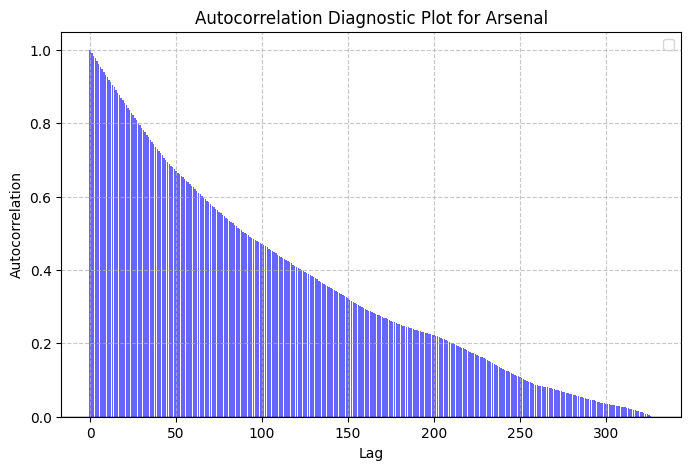

In [151]:
acf_values = autocorrelation_plot(strength_histories, 'Arsenal', max_lag = 100)

## MCMC(Update)

In [152]:
def create_season_dict(seasons_df, start_year, end_year, mu_p, sigma_p):
    """ 
    Returns dictionary, keys are years, values are season results
    and dictionary of strengths, all initialised
    """
    season_dict = {}
    strength_dict = {}
    
    for year in range(start_year, end_year + 1):
        season_data = seasons_df[seasons_df['Season_End_Year'] == year]
        season_dict[year] = season_data
        teams = get_teams(season_data)
        strength_dict[year] = [initialise_strengths(teams, mu_p, sigma_p)]
        
    return season_dict, strength_dict





In [153]:
season, strength = create_season_dict(seasons_df, 2016, 2018, 0, 0.1)

In [47]:
strength.get(2016)[-1]['Strength']

0    -0.002597
1     0.005120
2     0.093691
3    -0.005644
4    -0.026527
5    -0.099676
6     0.049501
7    -0.186188
8     0.064112
9    -0.069007
10    0.027290
11    0.005011
12   -0.043609
13    0.121150
14   -0.016821
15   -0.041183
16    0.026350
17   -0.242183
18   -0.034849
19    0.117067
Name: Strength, dtype: float64

In [99]:
def log_prior_strengths(current, previous, mu_p, sigma_p, eta, sigma_s):

    if previous is None:
        return initial_prior_strengths(current, mu_p, sigma_p)
    else:
        #prev_teams = list(previous.values())
        #curr_teams = list(current.values()) #lists of teams in previous and current season

        prev_teams = list(previous['Team Name'])
        curr_teams = list(current['Team Name']) #lists of teams in previous and current season

        promoted_teams = [team for team in curr_teams if team not in prev_teams] 
        remaining_teams = [team for team in curr_teams if team in prev_teams] #list of promoted and remaining teams
        prev_values = previous['Strength'].to_numpy()  # All previous strengths as numpy array
        curr_promoted_values = current[current['Team Name'].isin(promoted_teams)]['Strength'].to_numpy()
        curr_remaining_values = current[current['Team Name'].isin(remaining_teams)]['Strength'].to_numpy()
        prev_remaining_values = previous[previous['Team Name'].isin(remaining_teams)]['Strength'].to_numpy()

        avg_strength = np.mean(prev_values)

        promoted_log_likelihood = multivariate_normal.logpdf(
            curr_promoted_values,
            mean=np.full(len(promoted_teams), mu_p),  # vector of mu_p values
            cov=np.eye(len(promoted_teams)) * (sigma_p**2)  
        )

        mean_prior_remaining = eta * (prev_remaining_values - avg_strength)

        remaining_log_likelihood = multivariate_normal.logpdf(
            curr_remaining_values,
            mean=mean_prior_remaining,
            cov=np.eye(len(remaining_teams)) * (sigma_s**2)  # Diagonal covariance matrix
        )

        return promoted_log_likelihood + remaining_log_likelihood


In [100]:
current = initialise_strengths(get_teams(recent), -0.2, 0.5)
previous = initialise_strengths(get_teams(seasons_df[seasons_df['Season_End_Year'] == 2022]), 0, 0.1)
log_prior_strengths(current, previous, 0, 0.1, 1, 0.1)

np.float64(-244.71528002168137)

In [101]:
type(previous)

pandas.core.frame.DataFrame

In [102]:
list(previous.items())

[('Team Name',
  0             Arsenal
  1         Aston Villa
  2           Brentford
  3            Brighton
  4             Burnley
  5             Chelsea
  6      Crystal Palace
  7             Everton
  8        Leeds United
  9      Leicester City
  10          Liverpool
  11    Manchester City
  12     Manchester Utd
  13      Newcastle Utd
  14       Norwich City
  15        Southampton
  16          Tottenham
  17            Watford
  18           West Ham
  19             Wolves
  Name: Team Name, dtype: object),
 ('Strength',
  0     0.146796
  1    -0.024083
  2     0.050400
  3    -0.066475
  4    -0.157780
  5    -0.128198
  6    -0.087978
  7    -0.031669
  8     0.026399
  9    -0.057127
  10    0.014451
  11    0.154270
  12   -0.138394
  13   -0.033705
  14   -0.036593
  15    0.188330
  16    0.076629
  17    0.099584
  18   -0.004526
  19    0.049541
  Name: Strength, dtype: float64)]

In [103]:
def parameter_llk(season_dict, strength_dict, start_year, end_year, lambda_h, lambda_a, eta, sigma_s, mu_p, sigma_p):
    """ 
    Get log likelihood over whole season given parameters
    """
    season_df = season_dict.get(start_year)
    strength_df = strength_dict.get(start_year)[-1]
    
    proposed_prob = (
        initial_prior_strengths(strength_df, mu_p, sigma_p)
        + strength_llk(strength_df, season_df, lambda_h, lambda_a)
        )
    
    for year in range(start_year+1, end_year+1):
        season_df = season_dict.get(year)
        strength_df = strength_dict.get(year)[-1]
        prev_strength_df = strength_dict.get(year-1)[-1]

        proposed_prob += (
        log_prior_strengths(strength_df, prev_strength_df, mu_p, sigma_p, eta, sigma_s)
        + strength_llk(strength_df, season_df, lambda_h, lambda_a)
        )
    return proposed_prob

In [121]:
def mcmc(seasons_df, start_year, end_year, burn_in = 1000, iterations = 5000):
    """ 
    Multi season MCMC

    start year and end year inclusive
    """
    

    #initialise parameters
    parameters = initialise_parameters()
    #parameter_names = ['Home Advantage', 'Away Advantage', 'Eta', 'Sigma_S', 'Mu_P', 'Sigma_P']
    lambda_h = parameters['Home Advantage'][0]
    lambda_a = parameters['Away Advantage'][0]
    eta = parameters['Eta'][0]
    sigma_s = parameters['Sigma_S'][0]
    mu_p = parameters['Mu_P'][0]
    sigma_p = parameters['Sigma_P'][0]

    season_dict, strength_dict = create_season_dict(seasons_df, start_year, end_year, mu_p, sigma_p)
    #store season results and initialise strengths in dictionaries
    log_prob_dict_strength = {}
    log_prob_dict_parameter = {}
    
    # Acceptance tracking
    acceptance_counters = {
        'Strength': {'accepted': 0, 'total': 0},
        'Home Advantage': {'accepted': 0, 'total': 0},
        'Away Advantage': {'accepted': 0, 'total': 0},
        'Mu_P': {'accepted': 0, 'total': 0},
        'Sigma_P': {'accepted': 0, 'total': 0},
        'Eta': {'accepted': 0, 'total': 0},
        'Sigma_S': {'accepted': 0, 'total': 0}
    }
    
    num_teams = 20 #get total number of teams
    #initialise team strengths
    #parameters['Strength'] = [strength_df] #store initial strengths in parameter dataframe
    cov_matrix = 0.0002 * np.eye(num_teams) #can adjust

    for i in range(burn_in + iterations):
        if np.random.uniform(0, 1) < 0.8: #strength proposal
            if i >= burn_in:
                acceptance_counters['Strength']['total'] += 1 #add to total iterations

            year = np.random.randint(start_year, end_year + 1) #select random season
            season_df = season_dict.get(year) #get season results for that year
            strength_df = strength_dict.get(year)[-1]
            #get strengths for season
            proposed_strength = np.random.multivariate_normal(strength_df['Strength'], cov_matrix)
            proposed_strength_df = strength_df.copy()
            proposed_strength_df['Strength'] = proposed_strength  # Update strength
            if year == start_year:
                proposed_log_prob = (
                    initial_prior_strengths(proposed_strength_df, mu_p, sigma_p)
                    + strength_llk(proposed_strength_df, season_df, lambda_h, lambda_a)
                )
            else:
                prev_strength_df = strength_dict.get(year - 1, None)[-1]
                proposed_log_prob = (
                log_prior_strengths(proposed_strength_df, prev_strength_df, mu_p, sigma_p, eta, sigma_s)
                + strength_llk(proposed_strength_df, season_df, lambda_h, lambda_a)
                )

            prob_acceptance = np.exp(min(0, proposed_log_prob - log_prob_dict_strength.get(year, float('-inf'))))
            if np.random.uniform(0, 1) < prob_acceptance:
                strength_dict[year].append(proposed_strength_df)
                log_prob_dict_strength[year] = proposed_log_prob
                if i >= burn_in:
                    acceptance_counters['Strength']['accepted'] += 1
            
        else:
            index = np.random.randint(1, 5)
            if index == 1: #update home advantage
                if i >= burn_in:
                    acceptance_counters['Home Advantage']['total'] += 1
                proposed_lambda_h = np.random.lognormal(np.log(lambda_h), 0.01) #maybe adjust sigma here
                
                proposed_lambda_h_prob = parameter_llk(season_dict, strength_dict, start_year, end_year,
                                                       proposed_lambda_h, lambda_a, eta, sigma_s, mu_p, sigma_p)

                prob_acceptance = np.exp(min(0, proposed_lambda_h_prob - log_prob_dict_parameter.get('Home Advantage', float('-inf'))))
                if np.random.uniform(0, 1) < prob_acceptance:
                    lambda_h = proposed_lambda_h
                    log_prob_dict_parameter['Home Advantage'] = proposed_lambda_h_prob
                    if i >= burn_in:
                        acceptance_counters['Home Advantage']['accepted'] += 1
                parameters['Home Advantage'].append(lambda_h)
            elif index == 2: #update away advantage
                if i >= burn_in:
                    acceptance_counters['Away Advantage']['total'] += 1
                proposed_lambda_a = np.random.lognormal(np.log(lambda_a), 0.01) #maybe adjust sigma here
                proposed_lambda_a_prob = parameter_llk(season_dict, strength_dict, start_year, end_year,
                                                       lambda_h, proposed_lambda_a, eta, sigma_s, mu_p, sigma_p)
                prob_acceptance = np.exp(min(0, proposed_lambda_a_prob - log_prob_dict_parameter.get('Away Advantage', float('-inf'))))
                if np.random.uniform(0, 1) < prob_acceptance:
                    lambda_a = proposed_lambda_a
                    log_prob_dict_parameter['Away Advantage'] = proposed_lambda_a_prob
                    if i >= burn_in:
                        acceptance_counters['Away Advantage']['accepted'] += 1
                parameters['Away Advantage'].append(lambda_a)
            elif index == 3: #update remaining team parameters
                if i >= burn_in:
                    acceptance_counters['Mu_P']['total'] += 1
                    acceptance_counters['Sigma_P']['total'] += 1
                proposed_mu_p = np.random.normal(mu_p, np.sqrt(0.0002))
                proposed_sigma_p = np.random.normal(sigma_p, np.sqrt(0.0002))
                proposed_p_prob = parameter_llk(season_dict, strength_dict, start_year, end_year,
                                                lambda_h, lambda_a, eta, sigma_s, proposed_mu_p, proposed_sigma_p)
                prob_acceptance = np.exp(min(0, proposed_p_prob - log_prob_dict_parameter.get('Promoted', float('-inf'))))

                if np.random.uniform(0, 1) < prob_acceptance:
                    mu_p = proposed_mu_p
                    sigma_p = proposed_sigma_p
                    log_prob_dict_parameter['Promoted'] = proposed_p_prob
                    if i >= burn_in:
                        acceptance_counters['Mu_P']['accepted'] += 1
                        acceptance_counters['Sigma_P']['accepted'] += 1
                parameters['Mu_P'].append(mu_p)
                parameters['Sigma_P'].append(sigma_p)
            elif index == 4: #update promoting parameters
                if i >= burn_in:
                    acceptance_counters['Eta']['total'] += 1
                    acceptance_counters['Sigma_S']['total'] += 1
                proposed_eta = np.random.normal(eta, np.sqrt(0.01))
                proposed_sigma_s = np.random.lognormal(np.log(sigma_s), np.sqrt(0.005))
                proposed_s_prob = parameter_llk(season_dict, strength_dict, start_year, end_year,
                                                lambda_h, lambda_a, proposed_eta, proposed_sigma_s, mu_p, sigma_p)
                prob_acceptance = np.exp(min(0, proposed_s_prob - log_prob_dict_parameter.get('Remaining', float('-inf'))))
                if np.random.uniform(0, 1) < prob_acceptance:
                    eta = proposed_eta
                    sigma_s = proposed_sigma_s
                    log_prob_dict_parameter['Remaining'] = proposed_s_prob
                    if i >= burn_in:
                        acceptance_counters['Eta']['accepted'] += 1
                        acceptance_counters['Sigma_S']['accepted'] += 1
                parameters['Eta'].append(mu_p)
                parameters['Sigma_S'].append(sigma_p)
                
    for parameter in acceptance_counters:
        if parameter == 'Strength':
            pass
        else:
            accepted = acceptance_counters[parameter]['accepted']
            total = acceptance_counters[parameter]['total']
            acceptance_counters[parameter]['percentage'] = (accepted / total * 100) #calculate acceptance percentage
            parameters[parameter] = parameters[parameter][-total:] #take off burn in

    return [strength_dict, parameters, acceptance_counters]

In [123]:
strength_dict, parameters, acceptance_counters = mcmc(seasons_df, 2015, 2016, burn_in = 5000, iterations = 25000)

In [127]:
season_one = strength_dict[2015]
strength_histories_one = strengths_by_team(season_one)

/var/folders/k6/9xc0dh5s7dv0mk7cjplncm6w0000gn/T/ipykernel_20265/3435341792.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined_df['Strength History'] = joined_df.values.tolist()


In [154]:
acceptance_counters

{'Strength': {'accepted': 8791,
  'total': 12074,
  'percentage': 72.80934238860361},
 'Home Advantage': {'accepted': 179,
  'total': 967,
  'percentage': 18.510858324715613},
 'Away Advantage': {'accepted': 212,
  'total': 958,
  'percentage': 22.129436325678498},
 'Mu_P': {'accepted': 256, 'total': 1001, 'percentage': 25.574425574425575},
 'Sigma_P': {'accepted': 256, 'total': 1001, 'percentage': 25.574425574425575}}

In [158]:
strength_histories

,Team Name,Strength History
0,Arsenal,"[1.983231400882622, 1.9736676664295016, 1.9736..."
1,Aston Villa,"[1.2658828708128071, 1.277279571553916, 1.2772..."
2,Bournemouth,"[1.019274671073221, 1.012000795178362, 1.01200..."
3,Brentford,"[1.5370447913300656, 1.5372046510091222, 1.537..."
4,Brighton,"[1.6085649605168721, 1.6159103859768955, 1.615..."
5,Chelsea,"[1.3501103612537606, 1.330700299943528, 1.3307..."
6,Crystal Palace,"[1.2313020360487792, 1.2555854717922812, 1.255..."
7,Everton,"[1.3864439256174674, 1.4018037814028, 1.401803..."
8,Fulham,"[1.368202722916261, 1.3759993084564113, 1.3759..."
9,Leeds United,"[1.0063202586443973, 1.001678179026818, 1.0016..."


In [159]:
strength_histories_one

,Team Name,Strength History
0,Arsenal,"[1.290606428761178, 1.2939943917411536, 1.3098..."
1,Aston Villa,"[0.8844844531383238, 0.8919837107242181, 0.885..."
2,Burnley,"[1.1957951342794206, 1.205453492234572, 1.2163..."
3,Chelsea,"[0.6986910008370897, 0.7181318264516401, 0.711..."
4,Crystal Palace,"[0.7060541346347398, 0.6952667182793382, 0.705..."
5,Everton,"[-0.16920299970193298, -0.1722143316834134, -0..."
6,Hull City,"[1.0034479141691024, 0.9982858067713848, 1.002..."
7,Leicester City,"[0.8409467132704223, 0.8325522919693337, 0.814..."
8,Liverpool,"[1.8882414553461548, 1.8819674247689213, 1.879..."
9,Manchester City,"[1.2630026682894802, 1.2687417009715118, 1.273..."


In [194]:
print(len(list(strength_histories_one[strength_histories_one['Team Name'] == 'Chelsea']['Strength History'])[0]))
print(len(list(strength_histories_one[strength_histories_one['Team Name'] == 'Manchester City']['Strength History'])[0]))

8615
8615


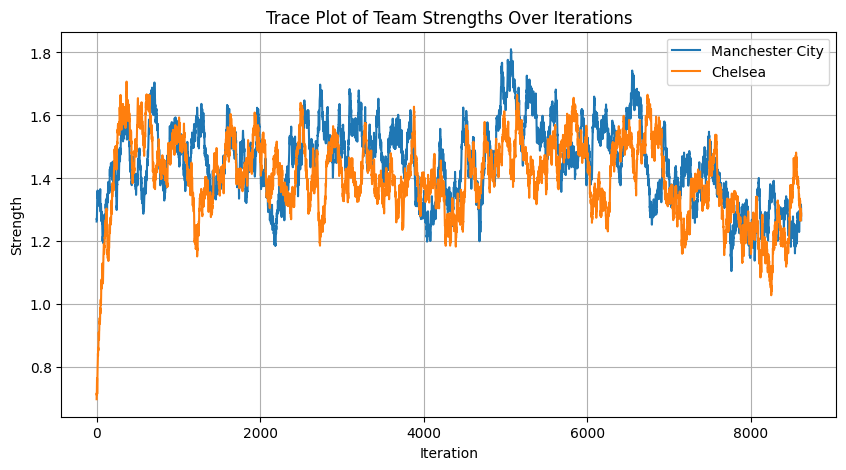

In [170]:
trace_plot_strength(strength_histories_one, ['Manchester City', 'Chelsea'])

Manchester City's strength was greater than Chelsea's strength in 63.44747533372026% of the iterations


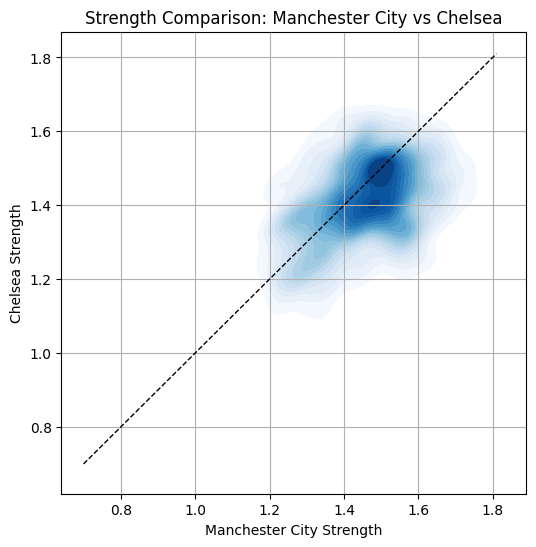

In [171]:
#comparison_plot(strength_histories_one, 'Leicester', 'Arsenal')
comparison_plot(strength_histories_one, 'Manchester City', 'Chelsea')

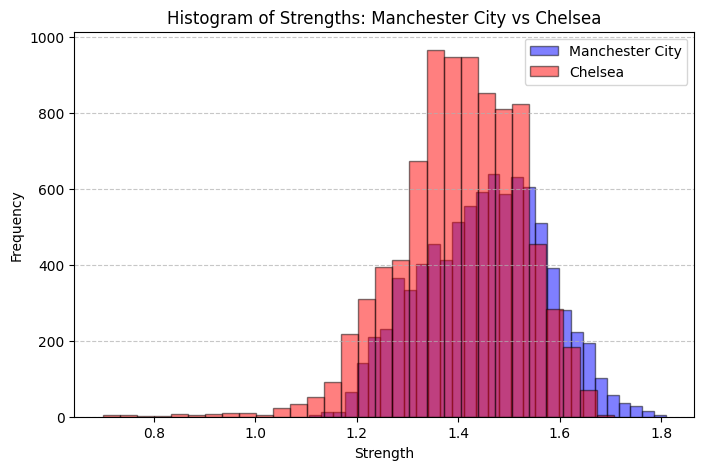

In [173]:
strength_histogram(strength_histories_one, 'Manchester City', 'Chelsea')


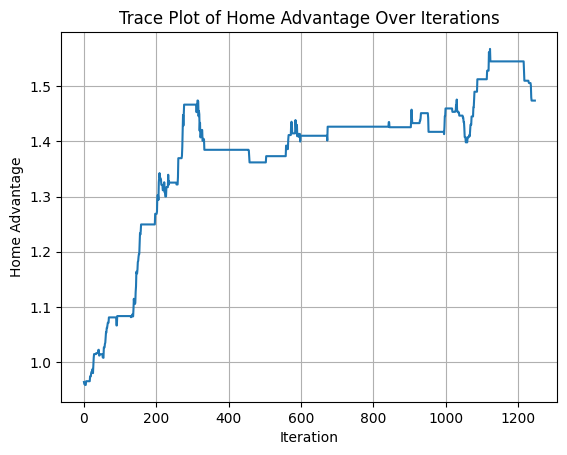

In [ ]:
trace_plot_parameter('Home Advantage', parameters)
#compare to real data

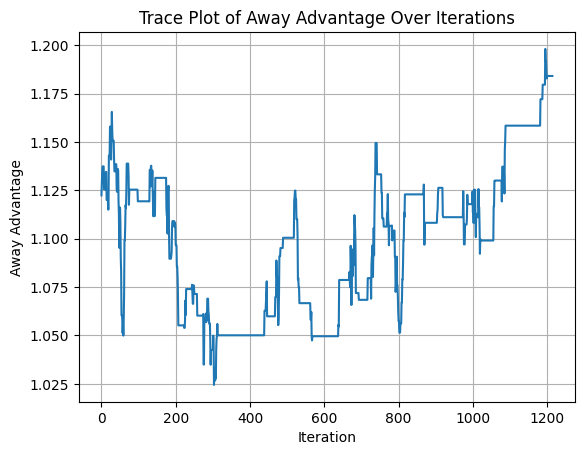

In [ ]:
trace_plot_parameter('Away Advantage', parameters)
#initialise around posterior mode

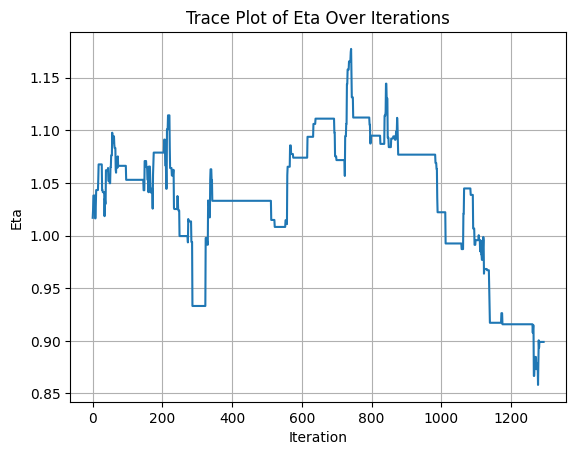

In [177]:
trace_plot_parameter('Eta', parameters)

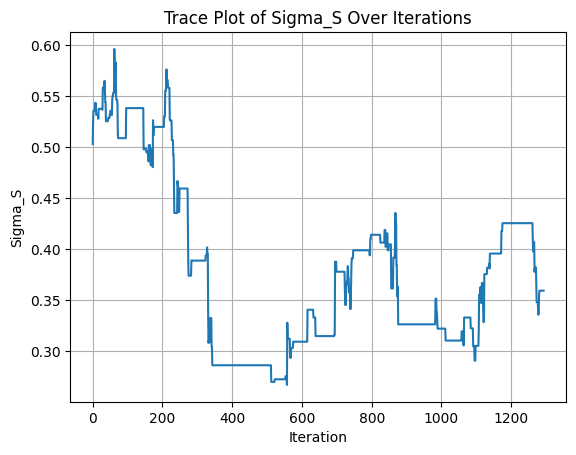

In [179]:
trace_plot_parameter('Sigma_S', parameters)

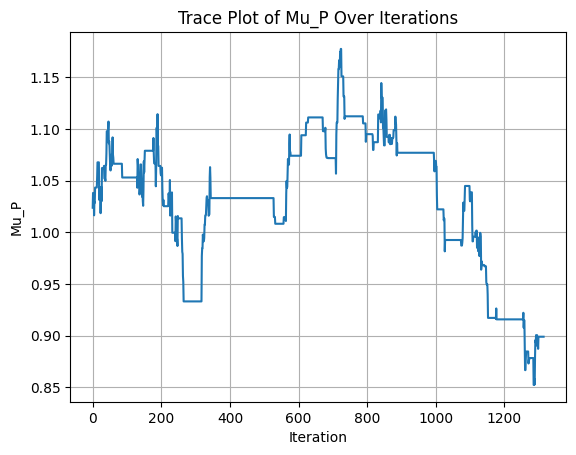

In [181]:
trace_plot_parameter('Mu_P', parameters)

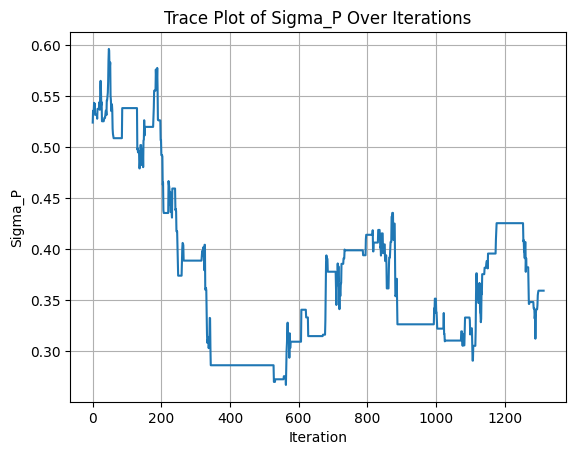

In [182]:
trace_plot_parameter('Sigma_P', parameters)

Effective Sample Size for Chelsea: 24.614739447393557 out of 8615


/var/folders/k6/9xc0dh5s7dv0mk7cjplncm6w0000gn/T/ipykernel_20265/180940785.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


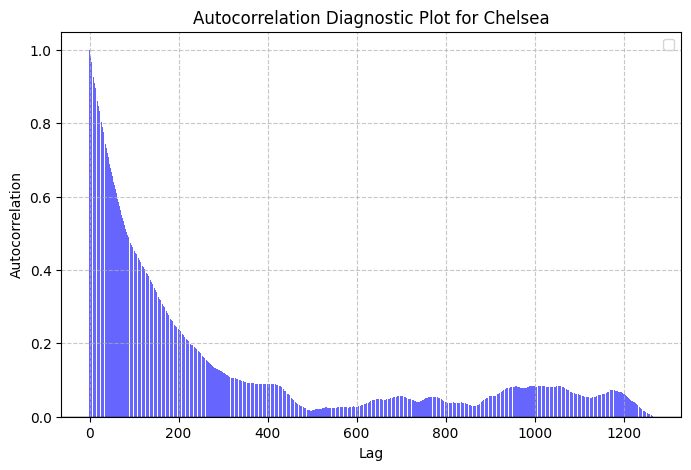

In [183]:
acf_values_one = autocorrelation_plot(strength_histories_one, 'Chelsea', max_lag = 100)